In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Generator
class Generator(nn.Module):
    def __init__(self, nz=100, ngf=64, nc=3):
        super().__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf*8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self, nc=3, ndf=64):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf*2, ndf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf*4, ndf*8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf*8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x).view(-1, 1).squeeze(1)

# Training
def train_dcgan(dataloader, epochs=25, nz=100, lr=0.0002, device='cuda'):
    # Initialize
    G = Generator(nz).to(device)
    D = Discriminator().to(device)
    G.apply(lambda m: nn.init.normal_(m.weight.data, 0.0, 0.02) if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)) else None)
    D.apply(lambda m: nn.init.normal_(m.weight.data, 0.0, 0.02) if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)) else None)

    criterion = nn.BCELoss()
    optimizerD = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))
    optimizerG = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))

    fixed_noise = torch.randn(64, nz, 1, 1, device=device)

    for epoch in range(epochs):
        for i, (data, _) in enumerate(dataloader):
            # Train Discriminator
            D.zero_grad()
            real = data.to(device)
            b_size = real.size(0)
            label = torch.full((b_size,), 1., dtype=torch.float, device=device)
            output = D(real)
            errD_real = criterion(output, label)
            errD_real.backward()

            noise = torch.randn(b_size, nz, 1, 1, device=device)
            fake = G(noise)
            label.fill_(0.)
            output = D(fake.detach())
            errD_fake = criterion(output, label)
            errD_fake.backward()
            optimizerD.step()

            # Train Generator
            G.zero_grad()
            label.fill_(1.)
            output = D(fake)
            errG = criterion(output, label)
            errG.backward()
            optimizerG.step()

            if i % 50 == 0:
                print(f'[{epoch}/{epochs}][{i}/{len(dataloader)}] Loss_D: {errD_real.item()+errD_fake.item():.4f} Loss_G: {errG.item():.4f}')

        # Save sample images
        with torch.no_grad():
            fake = G(fixed_noise)
            torchvision.utils.save_image(fake, f'fake_epoch_{epoch}.png', normalize=True)

    return G, D

# Usage
if __name__ == "__main__":
    # Load dataset (example with CIFAR-10, replace with your dataset)
    transform = transforms.Compose([
        transforms.Resize(64),
        transforms.CenterCrop(64),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    dataset = torchvision.datasets.CIFAR10(root='./data', download=True, transform=transform)
    dataloader = DataLoader(dataset, batch_size=128, shuffle=True, num_workers=2)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    G, D = train_dcgan(dataloader, epochs=25, device=device)

    # Generate new images
    with torch.no_grad():
        z = torch.randn(16, 100, 1, 1, device=device)
        generated = G(z)
        torchvision.utils.save_image(generated, 'generated_images.png', normalize=True, nrow=4)

100%|██████████| 170M/170M [00:03<00:00, 42.9MB/s]


[0/25][0/391] Loss_D: 1.3813 Loss_G: 0.7182
[0/25][50/391] Loss_D: 0.0986 Loss_G: 3.0766
[0/25][100/391] Loss_D: 0.0287 Loss_G: 4.3304
[0/25][150/391] Loss_D: 0.0441 Loss_G: 4.9138
[0/25][200/391] Loss_D: 0.0169 Loss_G: 5.2388
[0/25][250/391] Loss_D: 0.0065 Loss_G: 5.7742
[0/25][300/391] Loss_D: 0.1763 Loss_G: 4.1403
[0/25][350/391] Loss_D: 0.3838 Loss_G: 4.0686
[1/25][0/391] Loss_D: 0.9134 Loss_G: 5.7326
[1/25][50/391] Loss_D: 0.9147 Loss_G: 4.6715
[1/25][100/391] Loss_D: 0.2927 Loss_G: 5.5201
[1/25][150/391] Loss_D: 0.6668 Loss_G: 2.8023
[1/25][200/391] Loss_D: 0.4327 Loss_G: 3.0397
[1/25][250/391] Loss_D: 0.7621 Loss_G: 2.3877
[1/25][300/391] Loss_D: 0.3058 Loss_G: 2.8833
[1/25][350/391] Loss_D: 1.0874 Loss_G: 1.6671
[2/25][0/391] Loss_D: 1.0014 Loss_G: 1.5138
[2/25][50/391] Loss_D: 1.4735 Loss_G: 2.3062
[2/25][100/391] Loss_D: 0.7753 Loss_G: 1.9169
[2/25][150/391] Loss_D: 0.8361 Loss_G: 2.9544
[2/25][200/391] Loss_D: 0.8827 Loss_G: 1.7599
[2/25][250/391] Loss_D: 1.2333 Loss_G: 3.57

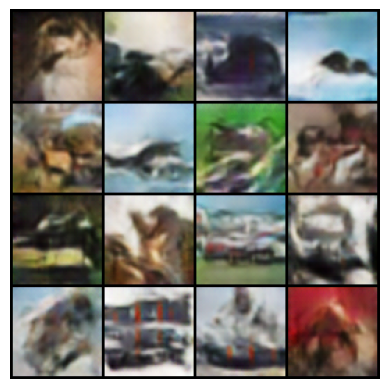

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread('generated_images.png')
plt.imshow(img)
plt.axis('off')
plt.show()
